# Load the pre saved model

In [20]:
from pickle import load
from keras.models import load_model

lmodel = load_model('cats-dogs-cnn-model1.h5')

# Image data setup & download

    - Once we have the data downloaded we will split the data into 3 folders
        - Training
        - Validation
        - Testing
        
    - You could do them manually OR via a program

In [ ]:
import os

base_dir = '.\dataset'

train_dir = os.path.join(base_dir,'training_set') 
train_dogs_dir = os.path.join(train_dir,'dogs') 
train_cats_dir = os.path.join(train_dir,'cats') 

validation_dir = os.path.join(base_dir,'test_set') 
validation_dogs_dir = os.path.join(validation_dir,'dogs') 
validation_cats_dir = os.path.join(validation_dir,'cats') 

test_dir = os.path.join(base_dir,'test_set') 
test_dogs_dir = os.path.join(test_dir,'dogs') 
test_cats_dir = os.path.join(test_dir,'cats') 

test_dir = os.path.join(base_dir,'test')

#print files count in each dire
print ('Number of files in dogs training images directory are ',len(os.listdir(train_dogs_dir)))
print ('Number of files in cats training images directory are ',len(os.listdir(train_cats_dir)))

print ('Number of files in dogs validation directory are ',len(os.listdir(validation_dogs_dir)))
print ('Number of files in cats validation directory are ',len(os.listdir(validation_cats_dir)))

print ('Number of files in dogs test directory are ',len(os.listdir(test_dogs_dir)))
print ('Number of files in cats test directory are ',len(os.listdir(test_cats_dir)))

## Step 1: Retrieve layers information from the model

In [ ]:
# Fetch the layers from the model object
layers = lmodel.layers

print ('Number of layers in network is %d'%(len(layers)))
for i in range(0,len(layers)):
    print ('Layer name is %s'%(layers[i].name))
    
num_conv_layers = 8 # currrently hardcoded but this could be read by parsing the names of the layers (we are interested in conv2d, maxpooling and flatten layers)

conv_layers_ouput = [layer.output for layer in lmodel.layers[:num_conv_layers]]
print ('Number of convolution layers in network are %d'%(len(conv_layers_ouput)))

# Step 2 Images data pre-processing

    - Once downloaded & split into folders we have the images as JPEG files. However before we can feed them into the network we need to convert them into right sized tensors; rough steps we would follow are
    
        - load jpeg files from disk
        - decode jpeg files to pixels grid
        - convert pixels grid to floating point tensors
        - rescale the pixel values (between 0 and 255) to values (between 0 and 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150,150), batch_size=20, class_mode='binary')

# Step 3 - Load a test image 

Predicted dog


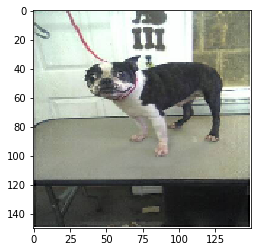

In [48]:
# Let's load a sample image and apply this image generator on it.
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt
%matplotlib inline

#get all filenames from training images of cats
fileNames = [os.path.join(train_dogs_dir,fname) for fname in os.listdir(train_dogs_dir)]

#select one cat image name for augmentation
sample_image_path = fileNames[5] 

#load sample image
sample_image = image.load_img(sample_image_path, target_size=(150,150))

#converts into numpy array of size (150,150,3)
testImage = image.img_to_array(sample_image)

plt.imshow(image.array_to_img(testImage.reshape(150,150,3)))

dogcat = lmodel.predict_classes(testImage.reshape(1,150,150,3))
if dogcat==1 :
    print ('Predicted dog')
else :
    print ('Predicted cat')

## Step 4: Create model object to capture activations/outputs from layers

In [32]:
from keras.models import Model

# Here we are defining a new type of model object; Model. This model takes the actual model as input, expected cnn layers as 
# output and loads the outputs.
activation_model = Model(inputs=lmodel.input, outputs=conv_layers_ouput)

activations = activation_model.predict(testImage.reshape(1,150,150,3))

## Step 5: Visualize activations

    - First layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture
    - As we go higher (or to 2nd, 3rd, 4th layer) the activations become increasingly abstract. They begin to encode higher level concepts such as 'ear','nose' etc Higher representations carry less information about the visual content of the image and increasingly more information about the class of the image - for e.g. a cat or a dog.
    - In higher layers, more and more activations are blank - which means that patterns encoded by the filters are not found in the image - which is fine.
    
    If we think for a moment about how humans think, after looking at an image/picture we tend to remember higher level objects and not the exact details. For e.g. if we were to draw a mobile ourselves we would draw basic structure even though we see a mobile 100 times in a day. CNN model does exactly that, with each layer the activations become more abstract and hence the model is able to learn more about the class

C:\MachineLearning\anaconda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


MemoryError: 

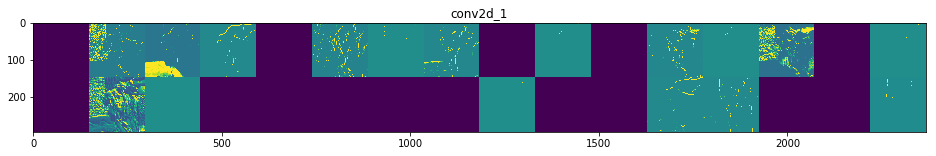

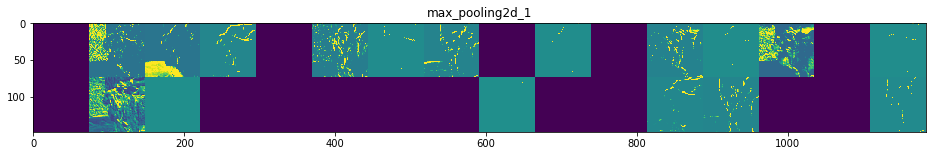

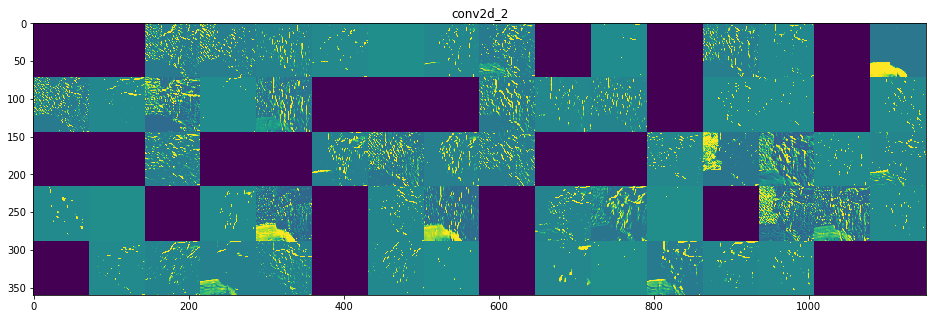

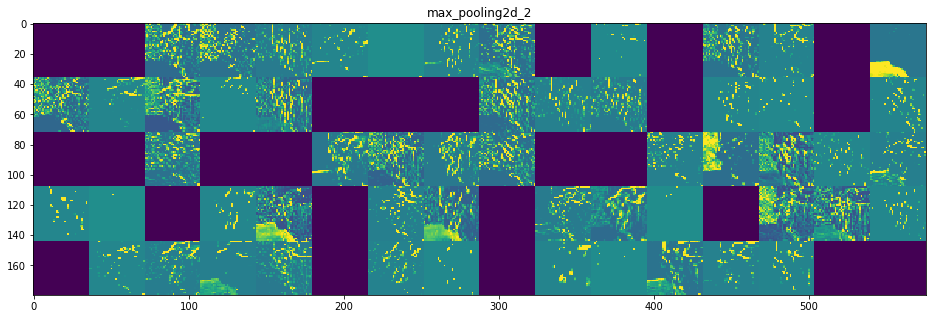

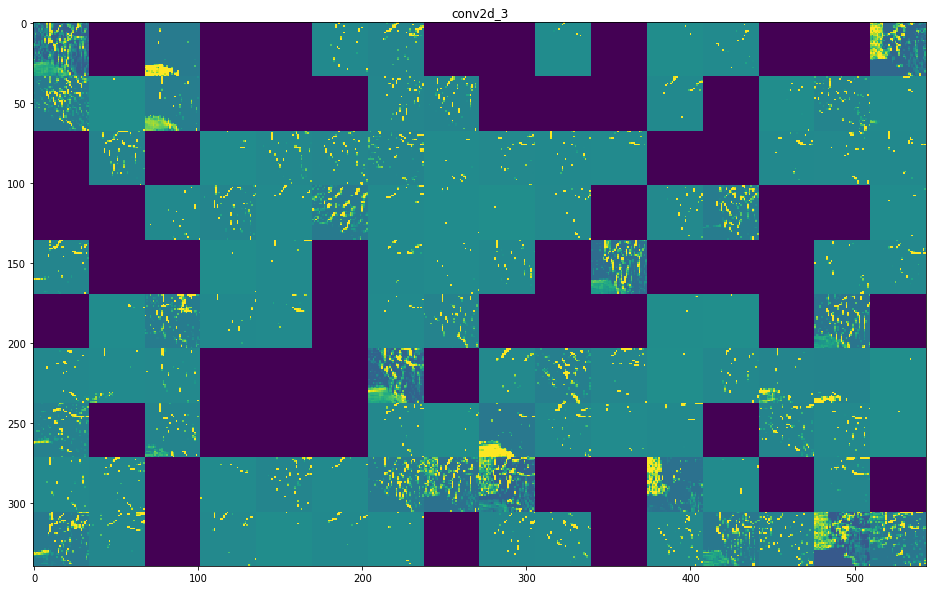

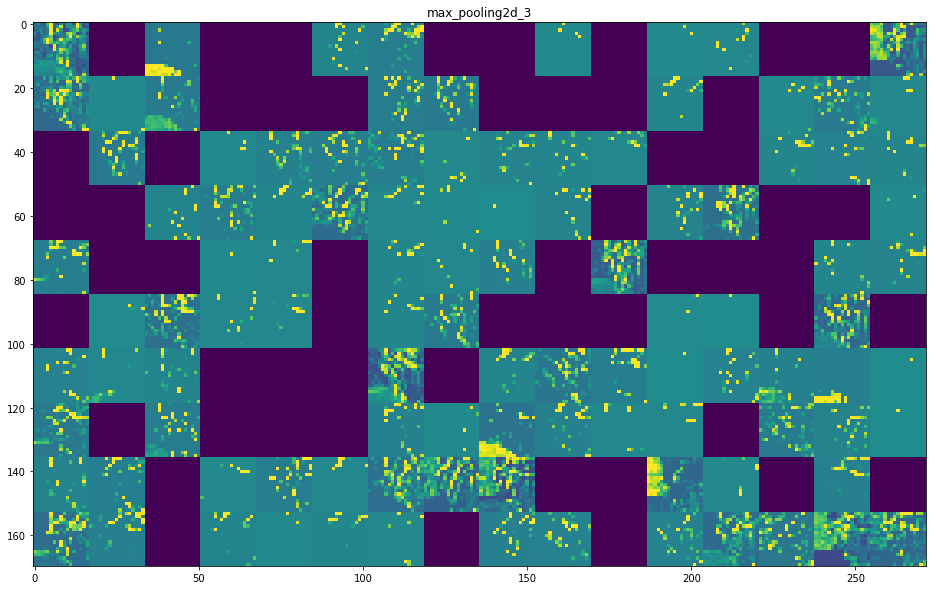

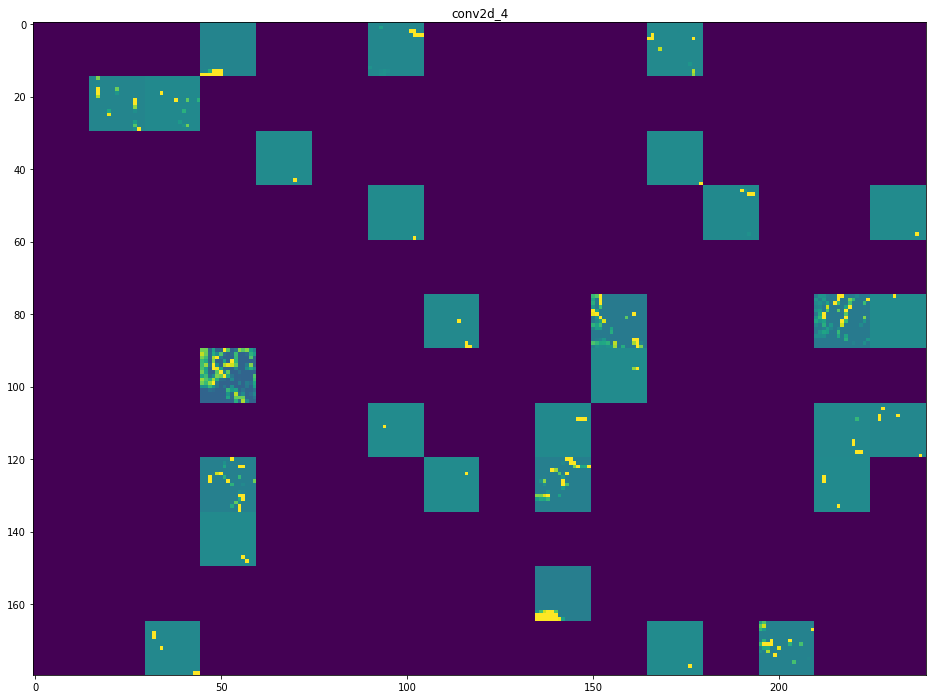

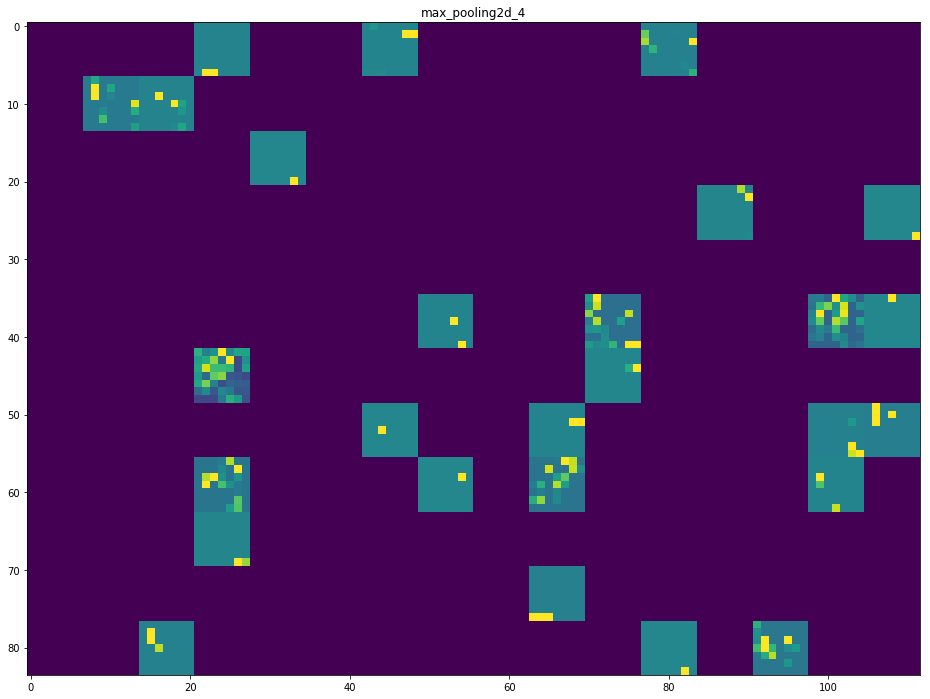

In [51]:
import numpy as np

layer_names = []
for layer in lmodel.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Visualizing Image Patterns which Activate Filters

    - Previously we visualized the activations (or outputs) of each layer. Now each layer has multiple filters in it.
    - Another way to visualize is to see which patterns in image activate each filter in the layer
    - This could be done as follows:
        - Get the output of a layer, this would be a tensor
        - Get the loss for a specific filter index (filter number)
        - Calculate the Gradients which would generate that loss
        - Create a dummy grey image
        - Now we apply a gradient ascent so that the loss is minimized for that filter.
            - Start with dummy image and find loss and gradient
            - This is done 40 times (arbitary choice) and fresh loss and gradients are calculated
            - We keep updating the image with new gradient values
        - We can apply this logic to print our those image patterns which activate all filters in a layer

In [201]:
import cv2

#Define regularizations:
def blur_regularization(img, size = (1, 1)):
    return cv2.blur(img, size)

def decay_regularization(img, decay = 0.9):
    return decay * img

def deprocess_image(img):
    #print ('Input shape of image is ', img.shape)
    
    img = img - img.mean()
    img = img / (img.std()+1e-5)
    img = img * 0.8
    imt = img+0.5
    img = np.clip(img,0,1)
    img = img*255
    img = np.clip(img,0,255).astype('uint8')
    return decay_regularization(img)

In [202]:
from keras import backend as K
    
def generate_pattern(model, layer_name, filter_index, num_filters, size=150):
    
    # Get the output of the specified layer
    layer_output = model.get_layer(layer_name).output
    #print ('Output of layer named %s is %s'%(layer_name, layer_output))
    
    # Get the loss of the specified filter index
    loss = K.mean(layer_output[:,:,:,:filter_index])
    #print ('Losss at filter %d of layer named %s is %s'%(filter_index, layer_name, loss))
    
    # Given the input and the loss calculate the gradients (or filter values)
    gradients = K.gradients(loss, model.input)[0]
    
    # Normalize Gradients
    gradients /= (K.sqrt(K.mean(K.square(gradients))) + 1e-5)    
    
    # Create a iterate function which gives the loss and gradient given input picture
    iterate = K.function([model.input],[loss, gradients])
    
    # Start with a simple blank image
    img = np.random.random((1,size,size,3)) * 20  # grey image
    
    step = .1
    for i in range (num_filters):
        loss_values, gradient_values = iterate([img])
        img=img+gradient_values*step
        
    #print (img.shape)
    img = img[0]
    #print (img.shape)
    
    #return img
    return deprocess_image(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


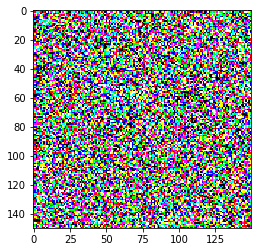

In [203]:
plt.imshow(generate_pattern(lmodel, 'conv2d_2', 1,80))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


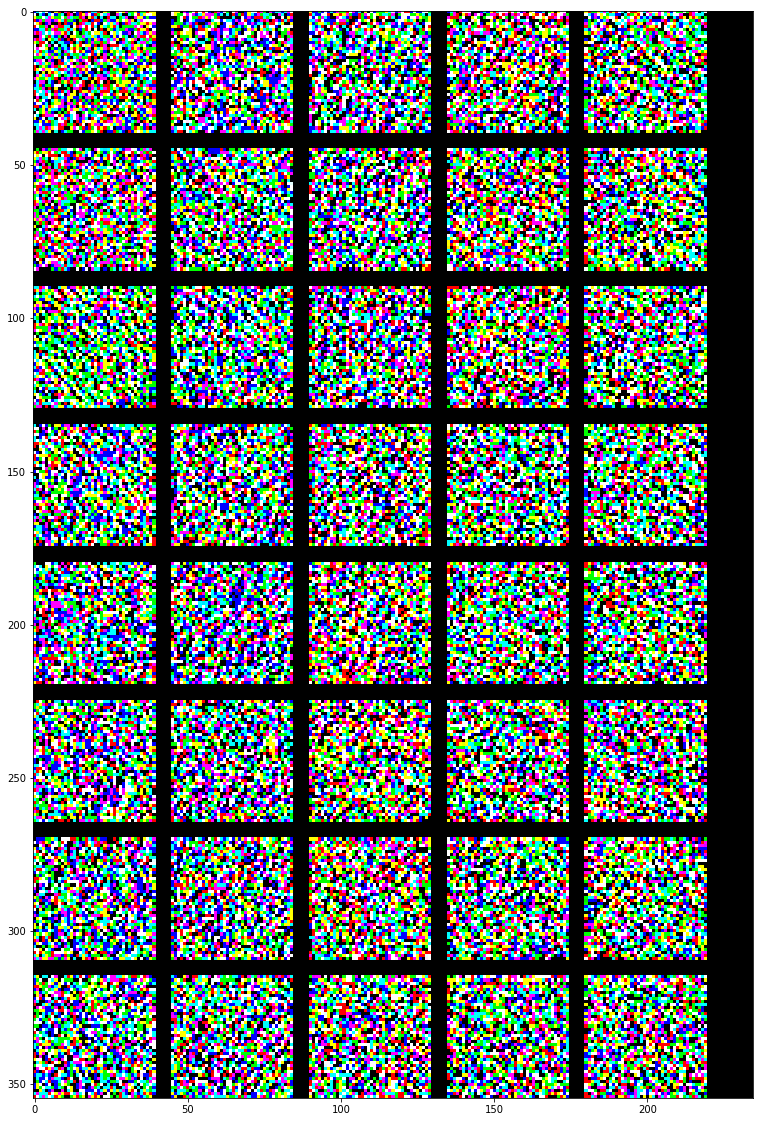

In [161]:
layer_name = 'conv2d_1'
size = 40
margin = 5
row_img = 8
col_img = 5

results = np.zeros((row_img*size+7*margin, col_img*size+7*margin,3))
for i in range (row_img):
    for j in range (col_img):
        filter_img = generate_pattern(lmodel, 'conv2d_1', i+(j*col_img), 40, size=size)
        horizontal_start = i*size+i*margin
        horizontal_end = horizontal_start + size
        vertical_start = j*size+j*margin
        vertical_end = vertical_start + size
        #print (horizontal_start,horizontal_end, vertical_start,vertical_end)
        results[horizontal_start:horizontal_end, vertical_start:vertical_end,:] = filter_img
        
plt.figure(figsize=(20,20))
plt.imshow(results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


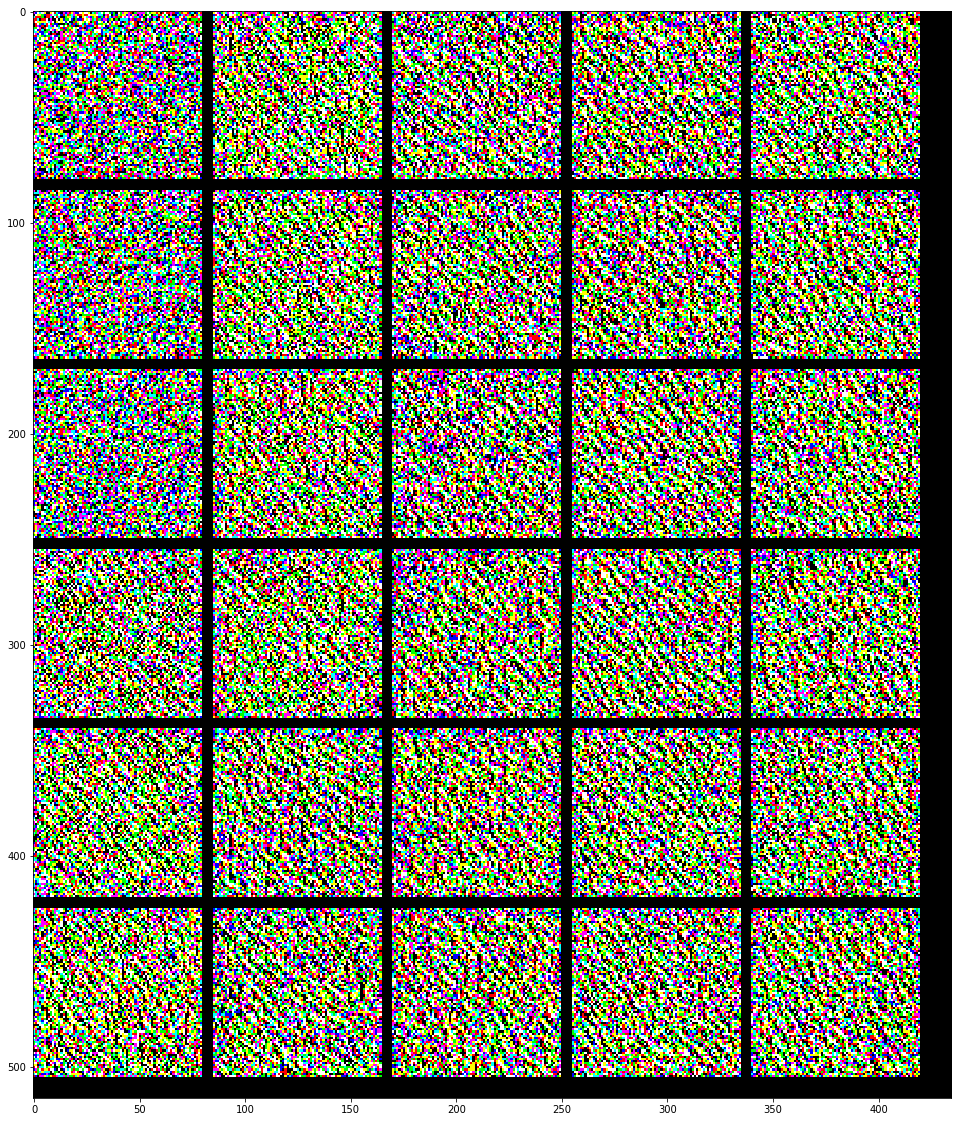

In [162]:
layer_name = 'conv2d_2'
size = 80
margin = 5
row_img = 6
col_img = 5

results = np.zeros((row_img*size+7*margin, col_img*size+7*margin,3))
for i in range (row_img):
    for j in range (col_img):
        filter_img = generate_pattern(lmodel, layer_name, i+(j*col_img), 80, size=size)
        horizontal_start = i*size+i*margin
        horizontal_end = horizontal_start + size
        vertical_start = j*size+j*margin
        vertical_end = vertical_start + size
        #print (horizontal_start,horizontal_end, vertical_start,vertical_end)
        results[horizontal_start:horizontal_end, vertical_start:vertical_end,:] = filter_img
        
plt.figure(figsize=(20,20))
plt.imshow(results)